In [1]:
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import decode_predictions
from tensorflow.keras.applications.resnet50 import preprocess_input
import numpy as np

In [2]:
import tensorflow as tf

In [3]:
# model = VGG16(weights='imagenet',
#                  include_top=False,
#                  input_shape=(32,32,3))

model = ResNet50(weights='imagenet')

102967424/102967424 [==============================] - 0s 0us/step


In [4]:
model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                           

In [5]:
image_file_name = 'cat.jpeg'

In [6]:
img = image.load_img(image_file_name, target_size=(224,224))

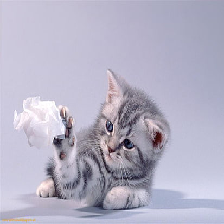

In [7]:
img

In [8]:
x = image.img_to_array(img)
print(x.shape)

(224, 224, 3)


In [9]:
x = np.expand_dims(x,axis=0)
print(x.shape)

(1, 224, 224, 3)


In [10]:
x = preprocess_input(x)
print(x.shape)

(1, 224, 224, 3)


In [11]:
preds = model.predict(x)

1/1 [==============================] - 8s 8s/step


In [12]:
print('predicted: ', decode_predictions(preds, top=3))

35363/35363 [==============================] - 0s 0us/step
predicted:  [[('n02124075', 'Egyptian_cat', 0.61833936), ('n02123045', 'tabby', 0.27405822), ('n02127052', 'lynx', 0.07440625)]]


In [13]:
##### 전이학습 시작 #####

In [14]:
(train_images_raw, train_labels_raw), (test_images, test_labels) = tf.keras.datasets.cifar100.load_data(label_mode='coarse')

169001437/169001437 [==============================] - 2s 0us/step


In [20]:
def preprocess_image_input(input_images):
  input_images = input_images.astype('float32')
  output_images = preprocess_input(input_images)
  return output_images

In [21]:
train_images = train_images_raw[:45000]
train_labels = train_labels_raw[:45000]

In [22]:
valid_images = train_images_raw[40000:]
valid_labels = train_labels_raw[40000:]

In [23]:
temp = []
for i in train_labels:
  if i not in temp:
    temp.append(i)

print("dataset super class labels: ",len(temp))

dataset super class labels:  20


In [24]:
train_X = preprocess_image_input(train_images)
valid_X = preprocess_image_input(valid_images)

In [25]:
feature_extractor = tf.keras.applications.resnet.ResNet50(input_shape=(224,224,3),
                                                include_top=False,
                                                weights='imagenet')

94765736/94765736 [==============================] - 0s 0us/step


In [26]:
feature_extractor.trainable = False

In [27]:
inputs = tf.keras.Input(shape=(32, 32, 3))
x = tf.keras.layers.UpSampling2D(size=(7,7))(inputs)
x = feature_extractor(x)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(1024, activation="relu")(x)
x = tf.keras.layers.Dense(512, activation="relu")(x)
# output classification count: 20
outputs = tf.keras.layers.Dense(20, activation="softmax", name="classification")(x)

In [28]:
model = tf.keras.Model(inputs=inputs, outputs=outputs)

In [29]:
model.compile(optimizer=tf.keras.optimizers.SGD(),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

In [30]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 up_sampling2d (UpSampling2D  (None, 224, 224, 3)      0         
 )                                                               
                                                                 
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 1024)              2098176   
                                                                 
 dense_1 (Dense)             (None, 512)               524800

In [31]:
EPOCHS = 5

history = model.fit(train_X, train_labels, epochs=EPOCHS,
                    validation_data=(valid_X, valid_labels), batch_size=100, shuffle=True)

Epoch 1/5
450/450 [==============================] - 180s 392ms/step - loss: 1.6074 - accuracy: 0.5022 - val_loss: 1.2487 - val_accuracy: 0.6004
Epoch 2/5
450/450 [==============================] - 176s 391ms/step - loss: 1.1847 - accuracy: 0.6217 - val_loss: 1.1260 - val_accuracy: 0.6387
Epoch 3/5
450/450 [==============================] - 176s 391ms/step - loss: 1.0609 - accuracy: 0.6599 - val_loss: 1.0458 - val_accuracy: 0.6659
Epoch 4/5
450/450 [==============================] - 176s 390ms/step - loss: 0.9846 - accuracy: 0.6834 - val_loss: 0.9907 - val_accuracy: 0.6854
Epoch 5/5
450/450 [==============================] - 176s 391ms/step - loss: 0.9283 - accuracy: 0.7001 - val_loss: 0.9424 - val_accuracy: 0.6948


In [33]:
test_images = preprocess_image_input(test_images)
results = model.evaluate(test_images, test_labels)
test = model.predict(test_images)
print(results[1])

313/313 [==============================] - 30s 95ms/step
0.6751999855041504


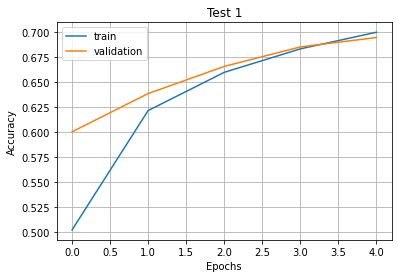

In [34]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Test 1')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train','validation'])
plt.grid()
plt.show()